In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import feature

from data_loader import Dataset

/Users/briancollins/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
Using TensorFlow backend.


In [2]:
d = Dataset('./TrainSmall2/TrainDotted/', './TrainSmall2/Train/')

# This is for preprocessing the images to capture each sea lion
dots, images = d.read_images()

# Using in the Neural Network. Currently not important.
# dot_arr, img_arr = d.load_training_data()

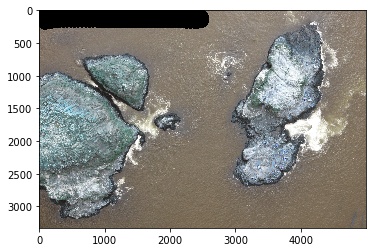

In [3]:
plt.imshow(dots[0])

##  PREPROCESSING ALL THE INDIVIDUAL SEA LIONS

#### TODO ####
- Currently saves all the coordinates
- Like to put all this in the data_loader class so that we can preprocess all the images from one class prior to modeling
- May be better to just build a new class to do all this
- May not matter, but the images are discolored because of loading in from OpenCV

In [4]:
sea_lion_dots = []
adult_males = []
subadult_males = []
pups = []
juveniles = []
adult_females = [] 

r = 0.4     #scale down
width = 100 #patch size 
file_names = os.listdir(r"./TrainSmall2/Train")
file_names = sorted(file_names, key=lambda
                    item: (int(item.partition('.')[0]) if item[0].isdigit() else float('inf'), item))

class_names = ['adult_females', 'adult_males', 'juveniles', 'pups', 'subadult_males']
coordinates_df = pd.DataFrame(index=file_names[:-1], columns=class_names)

for i, img in enumerate(dots):
    print(i)
    """Masking needs to occur twice to reduce the images enough for the dots to be focused on"""
    
    sea_lion_abs = cv2.absdiff(dots[i], images[i])
    mask = cv2.cvtColor(sea_lion_abs, cv2.COLOR_BGR2GRAY)
    mask[mask < 50] = 0
    mask[mask > 0] = 255
    sea_lion_bit = cv2.bitwise_or(sea_lion_abs, sea_lion_abs, mask=mask)
    
    mask = cv2.cvtColor(dots[i], cv2.COLOR_BGR2GRAY)

    mask[mask < 50] = 0
    mask[mask > 0] = 255
    sea_lion_bit = cv2.bitwise_or(sea_lion_abs, sea_lion_abs, mask=mask)

    # convert to grayscale to be accepted by skimage.feature.blob_log
    sea_lion_max = np.max(sea_lion_bit, axis=2)
    sea_lion_dots.append(sea_lion_max)

    blobs = feature.blob_log(sea_lion_max, min_sigma=3, max_sigma=7, num_sigma=1, threshold=0.05)

    h, w, d = sea_lion_abs.shape # (3328, 4992, 3)

    res = np.zeros((int((w * r) // width) + 1, int((h * r) // width) + 1, 5), dtype='int16')
    filename = file_names[i]


    image_circles = np.copy(dots[i])   # this copy will draw circles around the dots (colored by type)
    image_rectangles = np.copy(images[i])   # this copy will draw rectangles around 

    # half_size based on these:
    # females - 75
    # adult males - 120
    # juveniles - 60
    # pups - 40
    # subadult_males - ?

    # Loop through blobs - depending on type of sea lion type, mark them accordingly

    for blob in blobs:
            # get the coordinates for each blob
            y, x, s = blob


            # get the color of the pixel from Train Dotted in the center of the blob
            b, g, r = dots[i][int(y)][int(x)][:]


            #print(b, g, r)
            x1 = int((x * r) // width)
            y1 = int((y * r) // width)

            # decision tree to pick the class of the blob by looking at the color in Train Dotted
            # Adult males
            if  r > 200 and b < 50 and g < 50: 
                half_size = 60
                adult_males.append((int(x),int(y)))
                cv2.circle(image_circles, (int(x),int(y)), 20, (0,0,255), 10) 

                #### Test drawing rectangle for masks #### 

                cv2.rectangle(image_rectangles, 
                              (int(x - half_size), int(y + half_size)),
                              (int(x + half_size), int(y - half_size)),
                              (0,0,255), -2)

                #top left, bottom right # (x-width,y+height) (x+width,y-height)
                #### End rectangle code ####

            # Subadult males
            elif r > 200 and b > 200 and g < 50: # MAGENTA
                half_size = 40
                subadult_males.append((int(x), int(y))) 
                cv2.circle(image_circles, (int(x), int(y)), 20, (250, 10, 250), 10)
                cv2.rectangle(image_rectangles, 
                              (int(x - half_size), int(y + half_size)),
                              (int(x + half_size), int(y - half_size)),
                              (0, 0, 255), -2)

            # Pups
            elif r < 100 and b < 100 and 150 < g < 200: # GREEN
                half_size = 20
                pups.append((int(x), int(y)))
                cv2.circle(image_circles, (int(x), int(y)), 20, (20, 180, 35), 10)
                cv2.rectangle(image_rectangles, 
                              (int(x - half_size), int(y + half_size)),
                              (int(x + half_size), int(y - half_size)),
                              (0,0,255), -2)

            # Juveniles
            elif r < 100 and  100 < b and g < 100: # BLUE
                half_size = 30
                juveniles.append((int(x),int(y))) 
                cv2.circle(image_circles, (int(x), int(y)), 20, (180, 60, 30), 10)
                cv2.rectangle(image_rectangles, 
                              (int(x - half_size), int(y + half_size)),
                              (int(x + half_size), int(y - half_size)),
                              (0,0,255), -2)

            # Females
            elif r < 150 and b < 50 and g < 100:  # BROWN
                half_size = 40
                adult_females.append((int(x),int(y)))
                cv2.circle(image_circles, (int(x),int(y)), 20, (0,42,84), 10)  
                cv2.rectangle(image_rectangles, 
                              (int(x - half_size), int(y + half_size)),
                              (int(x + half_size), int(y - half_size)),
                              (0,0,255), -2)

            cv2.rectangle(images[i], (int(x) - 112, int(y) - 112), (int(x) + 112, int(y) + 112), 0, -1)

            coordinates_df["adult_males"][filename] = adult_males
            coordinates_df["subadult_males"][filename] = subadult_males
            coordinates_df["adult_females"][filename] = adult_females
            coordinates_df["juveniles"][filename] = juveniles
            coordinates_df["pups"][filename] = pups

    #Ideal chip sizes:
    # females - 75
    # adult males - 120
    # juveniles - 60
    # pups - 40
    # subadult_males - ?


0
1
2
3
4
5
6
7
8
9
